In [1]:
import torch
import sys, os
import argparse
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from sam_segment import predict_masks_with_sam
from lama_inpaint import inpaint_img_with_lama
from utils import load_img_to_array, save_array_to_img, dilate_mask, \
    show_mask, show_points, get_clicked_point

/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/coss07/anaconda3/envs/IA/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-11-28 14:08:50.619718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 14:08:50.619757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 14:08:50.619808: E tensorflow/com

Detectron v2 is not installed


In [3]:
img_folder_path =f'../wim_data/train/images/'
txt_folder_path = f'../wim_data/train/labels/'

In [4]:
input_img = '../wim_data/train/images/2023-04-21_48.mp4#t=0.jpg'
sam_model_type = "vit_h"
sam_ckpt = './pretrained_models/sam_vit_h_4b8939.pth'

In [15]:
img_file = '2023-04-21_48.mp4#t=0.jpg'
txt_file = os.path.join(txt_folder_path, os.path.splitext(img_file)[0] + '.txt')
txt_file

'../wim_data/train/labels/2023-04-21_48.mp4#t=0.txt'

('2023-04-21_48.mp4#t=0', '.jpg')

In [7]:
def normalized_coordinate_to_absolute(norm_x, norm_y, image_width=1280, image_height=720):
    abs_x = int(norm_x * image_width)
    abs_y = int(norm_y * image_height)
    return [abs_x, abs_y]

In [8]:
absolute_coordinates = []

with open(txt_file, 'r') as file:
    lines = file.readlines()
    for line in lines:
        class_id, x_center, y_center, width, height = line.strip().split()
        absolute_coordinates.append(normalized_coordinate_to_absolute(float(x_center), float(y_center)))
absolute_coordinates

[[435, 627],
 [546, 613],
 [520, 413],
 [654, 284],
 [673, 54],
 [565, 79],
 [396, 111],
 [803, 144]]

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
img = load_img_to_array(img_folder_path+ img_file)
coordinates = np.array(absolute_coordinates)
point_labels = np.ones(len(absolute_coordinates))

In [10]:
masks, _, _ = predict_masks_with_sam(
        img,
        coordinates,
        point_labels,
        model_type=sam_model_type,
        ckpt_p=sam_ckpt,
        device=device,
    )

In [11]:
masks.shape

(3, 720, 1280)

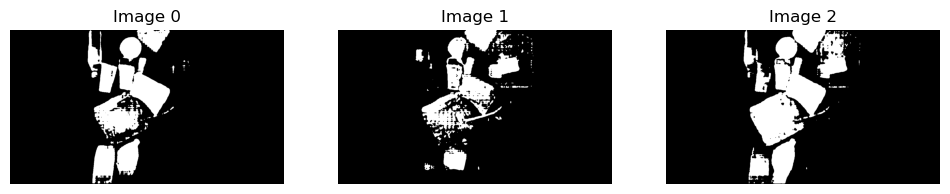

In [12]:
# 이미지의 개수
num_images = masks.shape[0]

# 한 번에 표시할 이미지의 개수
images_per_row = 3
%matplotlib inline
# 전체 이미지를 통해 반복
for i in range(0, num_images, images_per_row):
    plt.figure(figsize=(12, 4))
    for j in range(images_per_row):
        # 현재 인덱스 계산
        index = i + j
        if index < num_images:
            ax = plt.subplot(1, images_per_row, j + 1)
            img_to_show = masks[index].astype(int)
            ax.imshow(img_to_show, cmap='gray')  # 'gray' 컬러맵 사용
            #print(img_to_show)
            ax.title.set_text(f'Image {index}')
            plt.axis('off')
    plt.show()

In [23]:
image_files = [f for f in os.listdir(img_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
print(len(image_files))

800


In [17]:
img_folder_path =f'../wim_data/train/images/'
txt_folder_path = f'../wim_data/train/labels/'
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model_type = "vit_h"
sam_ckpt = './pretrained_models/sam_vit_h_4b8939.pth'

In [24]:
mask_path = '../wim_data/object_processing/'

for img in image_files:
    file_name = os.path.splitext(img)[0]
    txt_file = os.path.join(txt_folder_path, file_name + '.txt')
    
    absolute_coordinates = []
    with open(txt_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = line.strip().split()
            absolute_coordinates.append(normalized_coordinate_to_absolute(float(x_center), float(y_center)))
    image_file = load_img_to_array(img_folder_path+ img)
    coordinates = np.array(absolute_coordinates)
    point_labels = np.ones(len(absolute_coordinates))

    masks, _, _ = predict_masks_with_sam(
        image_file,
        coordinates,
        point_labels,
        model_type=sam_model_type,
        ckpt_p=sam_ckpt,
        device=device
    )
    masks = masks.astype(np.uint8)* 255
    mask = masks[2]

    mask_name = file_name +'_mask.jpg'
    save_array_to_img(mask, mask_path+mask_name)
    

In [ ]:
masks[2]

In [ ]:


for index, row in df.iterrows():
    input_img = img_folder_path + row.file_id + '.jpg'
    img = load_img_to_array(input_img)
    x_center = row.x_center
    y_center = row.y_center
    latest_coords = normalized_coordinate_to_absolute(x_center, y_center)
    
    masks, _, _ = predict_masks_with_sam(
        img,
        [latest_coords],
        point_labels,
        model_type=sam_model_type,
        ckpt_p=sam_ckpt,
        device=device,
    )
    masks = masks.astype(np.uint8)* 255
    mask = masks[2]
    
    extracted_object = cv2.bitwise_and(img, img, mask=mask)
    x, y, w, h = cv2.boundingRect(mask)
    cropped_object = cv2.cvtColor(extracted_object[y:y+h, x:x+w], cv2.COLOR_BGR2RGB)
    
    mask_name = row.file_id +'_'+ str(row.label)+'_'+ str(row.x_center)+'_' + str(row.y_center)+'.jpg'
    save_array_to_img(mask, mask_path+mask_name)
    
    object_name = row.file_id +'_'+ str(row.label) +'_'+ str(row.x_center)+'_' + str(row.y_center)+'.jpg'
    save_array_to_img(cropped_object, ob_path+object_name)
    
    